In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import logging
from scipy import stats

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to calculate evaluation metrics
def calculate_metrics(observed, predicted):
    metrics = {}
    metrics['MBE'] = np.mean(predicted - observed)
    metrics['MAE'] = np.mean(np.abs(predicted - observed))
    metrics['RMSE'] = np.sqrt(np.mean((predicted - observed)**2))
    metrics['PBIAS'] = 100 * np.sum(predicted - observed) / np.sum(observed) if np.sum(observed) != 0 else np.nan
    metrics['NSE'] = 1 - (np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)) if np.sum((observed - np.mean(observed))**2) != 0 else np.nan
    metrics['R'] = np.corrcoef(observed, predicted)[0, 1] if np.std(observed) != 0 and np.std(predicted) != 0 else np.nan
    return metrics

# Function to calculate MFB
def calculate_mfb(observed, predicted):
    return np.sum(predicted) / np.sum(observed)

# Function for overall statistical tests
def overall_statistical_tests(original, corrected, observed):
    results = {}
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(np.abs(original - observed), np.abs(corrected - observed))
    results['t_test'] = {'statistic': t_stat, 'p_value': p_value}
    
    # Wilcoxon signed-rank test
    w_stat, w_p_value = stats.wilcoxon(np.abs(original - observed), np.abs(corrected - observed))
    results['wilcoxon'] = {'statistic': w_stat, 'p_value': w_p_value}
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p_value = stats.ks_2samp(np.abs(original - observed), np.abs(corrected - observed))
    results['ks_test'] = {'statistic': ks_stat, 'p_value': ks_p_value}
    
    return results

# Directory containing the results files
results_dir = './zProcessing_temp/0results_bias/'

# Get all CSV files in the directory
result_files = glob(os.path.join(results_dir, 'results_*.csv'))
logging.info(f"Found {len(result_files)} CSV files in the directory")

# Dictionary to store results for each method
all_results = {}

# Process each file
for file in result_files:
    try:
        method_name = os.path.splitext(os.path.basename(file))[0].split('_')[1]
        logging.info(f"Processing file: {file}")
        
        df = pd.read_csv(file)
        logging.info(f"Columns in the file: {df.columns.tolist()}")
        
        required_columns = ['rain', 'radar_rainfall', 'radar_rainfall_adjusted']
        if not all(col in df.columns for col in required_columns):
            logging.error(f"Required columns not found in {file}")
            continue
        
        # Calculate metrics for original radar rainfall
        metrics_original = calculate_metrics(df['rain'], df['radar_rainfall'])
        mfb_original = calculate_mfb(df['rain'], df['radar_rainfall'])
        
        # Calculate metrics for corrected radar rainfall
        metrics_corrected = calculate_metrics(df['rain'], df['radar_rainfall_adjusted'])
        mfb_corrected = calculate_mfb(df['rain'], df['radar_rainfall_adjusted'])
        
        # Perform statistical tests
        statistical_tests = overall_statistical_tests(df['radar_rainfall'], df['radar_rainfall_adjusted'], df['rain'])
        
        all_results[method_name] = {
            'original': {'metrics': metrics_original, 'mfb': mfb_original},
            'corrected': {'metrics': metrics_corrected, 'mfb': mfb_corrected},
            'statistical_tests': statistical_tests
        }
        
        logging.info(f"Successfully processed {method_name}")
    except Exception as e:
        logging.error(f"Error processing {file}: {str(e)}")

# Print results
print("Comparison of Bias Correction Methods:")
print("======================================")

for method, results in all_results.items():
    print(f"\nMethod: {method.upper()}")
    print("--------------------")
    
    print("Original Radar Rainfall:")
    for key, value in results['original']['metrics'].items():
        print(f"  {key}: {value:.4f}")
    print(f"  MFB: {results['original']['mfb']:.4f}")
    
    print("\nCorrected Radar Rainfall:")
    for key, value in results['corrected']['metrics'].items():
        print(f"  {key}: {value:.4f}")
    print(f"  MFB: {results['corrected']['mfb']:.4f}")
    
    # Calculate improvements
    improvements = {}
    for key in results['original']['metrics'].keys():
        if key in ['MBE', 'MAE', 'RMSE', 'PBIAS']:
            improvements[key] = ((results['original']['metrics'][key] - results['corrected']['metrics'][key]) / 
                                 results['original']['metrics'][key]) * 100
        elif key in ['NSE', 'R']:
            improvements[key] = ((results['corrected']['metrics'][key] - results['original']['metrics'][key]) / 
                                 (1 - results['original']['metrics'][key])) * 100 if results['original']['metrics'][key] != 1 else 0
    
    mfb_improvement = (abs(results['original']['mfb'] - 1) - abs(results['corrected']['mfb'] - 1)) / abs(results['original']['mfb'] - 1) * 100
    
    print("\nImprovements:")
    for key, value in improvements.items():
        print(f"  {key}: {value:.2f}%")
    print(f"  MFB: {mfb_improvement:.2f}%")
    
    print("\nStatistical Tests:")
    for test, test_results in results['statistical_tests'].items():
        print(f"  {test}: statistic = {test_results['statistic']:.4f}, p-value = {test_results['p_value']:.4f}")
    
    print("\n")

# Print overall comparison
print("Overall Comparison of Methods:")
print("==============================")
metrics_to_compare = ['RMSE', 'NSE', 'R', 'MFB', 'PBIAS', 'MBE', 'MAE']
method_order = ['global', 'local', 'DistanceWeighted.', 'OptimizedDistanceWeighted', 'rf']

for metric in metrics_to_compare:
    print(f"\n{metric}:")
    for method in method_order:
        if method in all_results:
            value = all_results[method]['corrected']['metrics'].get(metric, all_results[method]['corrected']['mfb'])
            print(f"  {method}: {value:.4f}")
        else:
            print(f"  {method}: N/A")

print("\nStatistical Tests:")
for test in ['t_test', 'wilcoxon', 'ks_test']:
    print(f"\n{test.capitalize()}:")
    for method in method_order:
        if method in all_results:
            test_results = all_results[method]['statistical_tests'][test]
            print(f"  {method}: statistic = {test_results['statistic']:.4f}, p-value = {test_results['p_value']:.4f}")
        else:
            print(f"  {method}: N/A")

2024-08-23 18:29:34,002 - INFO - Found 5 CSV files in the directory
2024-08-23 18:29:34,003 - INFO - Processing file: ./zProcessing_temp/0results_bias\results_DistanceWeighted.csv
2024-08-23 18:29:34,014 - INFO - Columns in the file: ['fold', 'longitude', 'latitude', 'rain', 'radar_rainfall', 'radar_rainfall_adjusted', 'bias_original', 'bias_adjusted']
2024-08-23 18:29:34,023 - INFO - Successfully processed DistanceWeighted
2024-08-23 18:29:34,024 - INFO - Processing file: ./zProcessing_temp/0results_bias\results_global.csv
2024-08-23 18:29:34,032 - INFO - Columns in the file: ['fold', 'longitude', 'latitude', 'rain', 'radar_rainfall', 'radar_rainfall_adjusted', 'bias_original', 'bias_adjusted']
2024-08-23 18:29:34,038 - INFO - Successfully processed global
2024-08-23 18:29:34,038 - INFO - Processing file: ./zProcessing_temp/0results_bias\results_local.csv
2024-08-23 18:29:34,047 - INFO - Columns in the file: ['fold', 'longitude', 'latitude', 'rain', 'radar_rainfall', 'radar_rainfall_a

Comparison of Bias Correction Methods:

Method: DISTANCEWEIGHTED
--------------------
Original Radar Rainfall:
  MBE: -14.3464
  MAE: 36.7990
  RMSE: 52.4105
  PBIAS: -28.9488
  NSE: -0.3444
  R: 0.2462
  MFB: 0.7105

Corrected Radar Rainfall:
  MBE: -7.2234
  MAE: 31.1701
  RMSE: 45.4716
  PBIAS: -14.5758
  NSE: -0.0120
  R: 0.4150
  MFB: 0.8542

Improvements:
  MBE: 49.65%
  MAE: 15.30%
  RMSE: 13.24%
  PBIAS: 49.65%
  NSE: 24.73%
  R: 22.40%
  MFB: 49.65%

Statistical Tests:
  t_test: statistic = 7.2793, p-value = 0.0000
  wilcoxon: statistic = 146104.0000, p-value = 0.0000
  ks_test: statistic = 0.1074, p-value = 0.0000



Method: GLOBAL
--------------------
Original Radar Rainfall:
  MBE: -14.3464
  MAE: 36.7990
  RMSE: 52.4105
  PBIAS: -28.9488
  NSE: -0.3444
  R: 0.2462
  MFB: 0.7105

Corrected Radar Rainfall:
  MBE: 0.4273
  MAE: 43.3373
  RMSE: 59.9771
  PBIAS: 0.8622
  NSE: -0.7606
  R: 0.2412
  MFB: 1.0086

Improvements:
  MBE: 102.98%
  MAE: -17.77%
  RMSE: -14.44%
  PBIAS:

# Spatial bias

C:\Users\Admin\AppData\Local\Temp\ipykernel_3576\1130924764.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


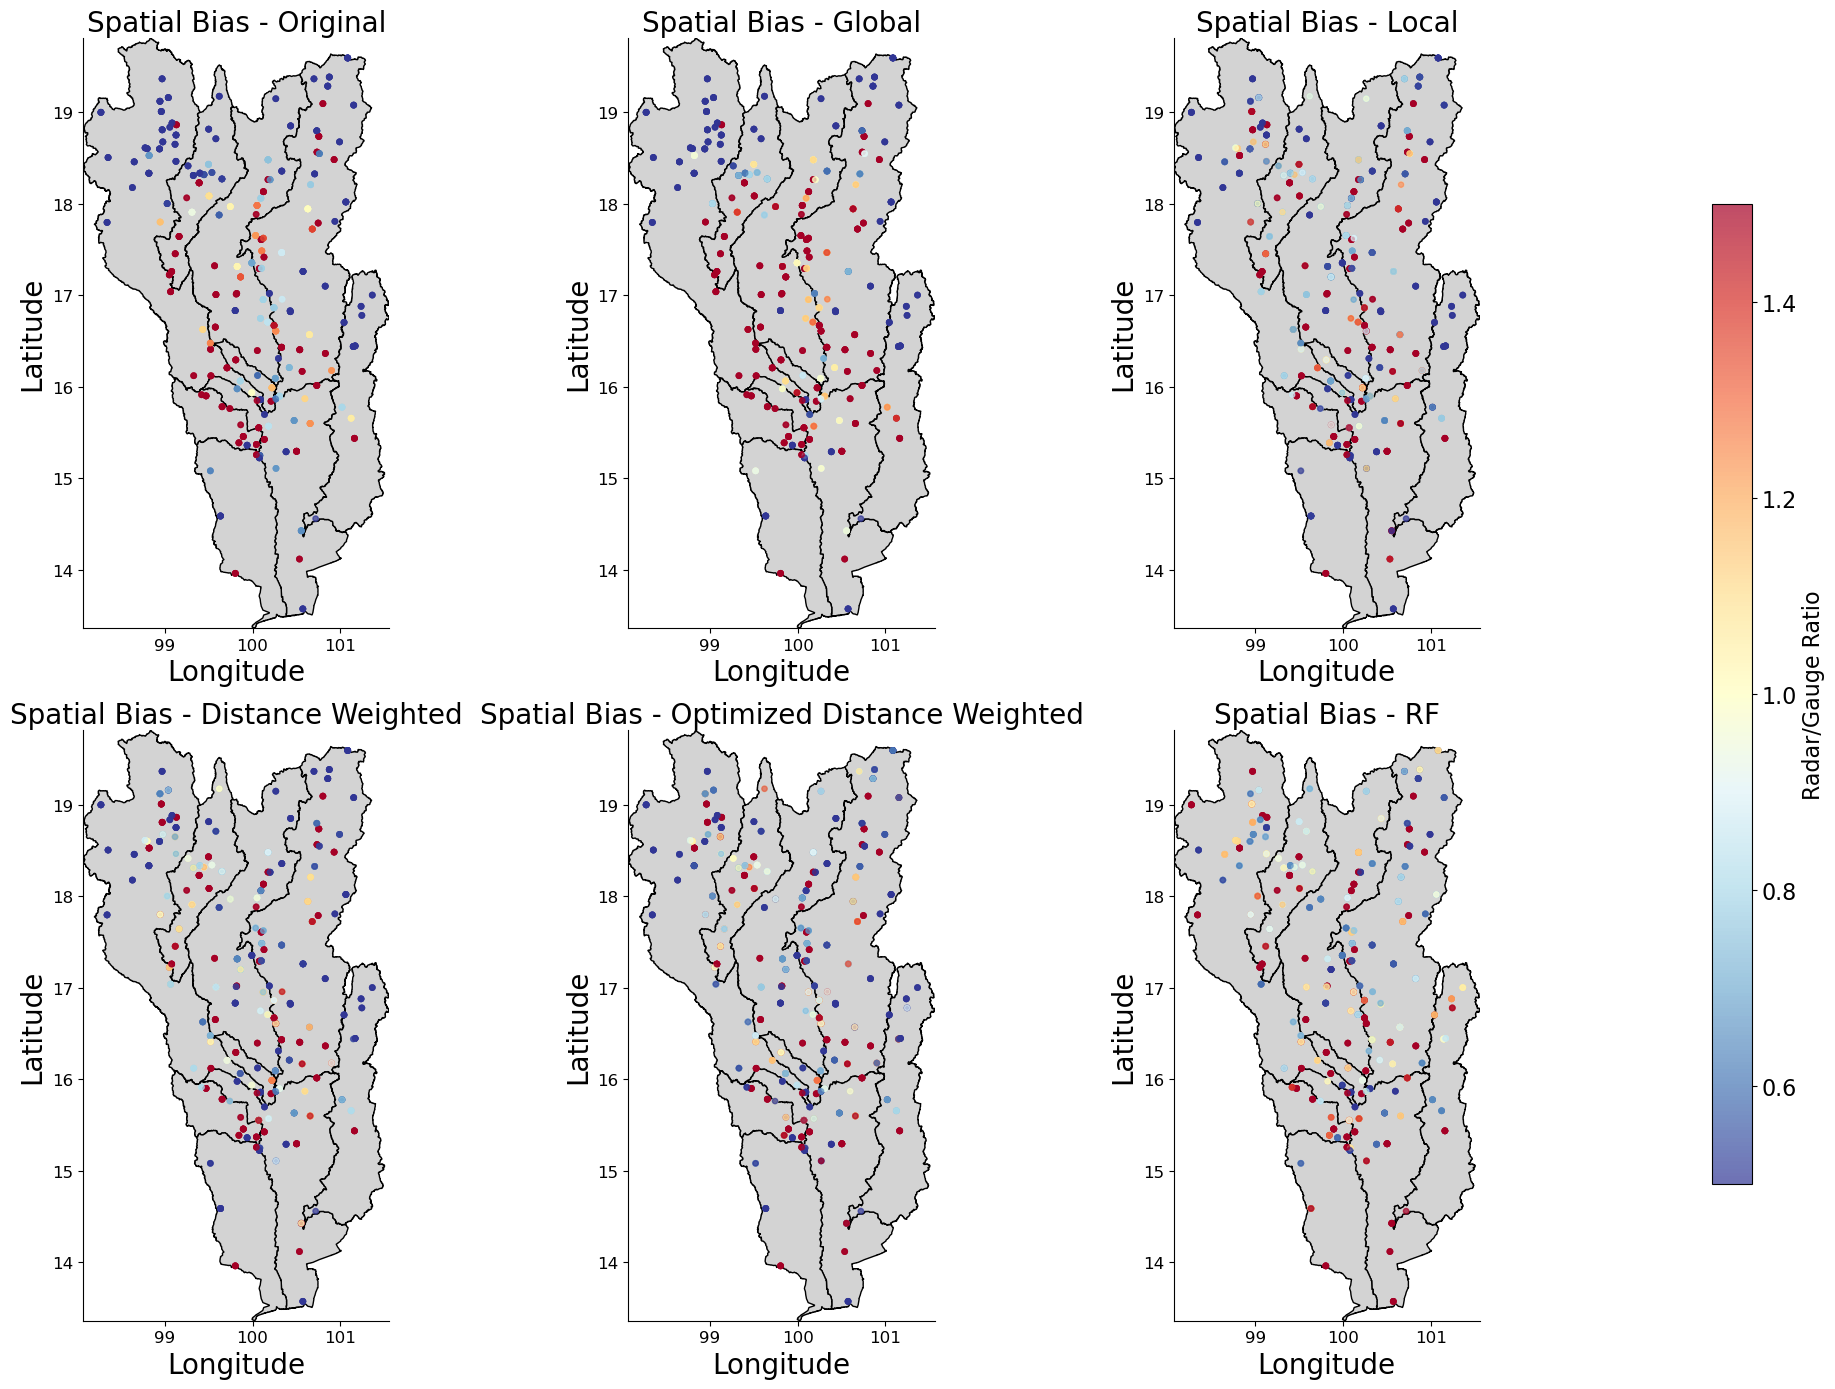

Metrics and MFB for each method:

Original:
MBE: -14.3464
MAE: 36.7990
RMSE: 52.4105
PBIAS: -28.9488
NSE: -0.3444
R: 0.2462
MFB: 0.7105

global:
MBE: 0.4273
MAE: 43.3373
RMSE: 59.9771
PBIAS: 0.8622
NSE: -0.7606
R: 0.2412
MFB: 1.0086

local:
MBE: -5.3402
MAE: 31.0301
RMSE: 44.4259
PBIAS: -10.7758
NSE: 0.0340
R: 0.4676
MFB: 0.8922

DistanceWeighted:
MBE: -7.2234
MAE: 31.1701
RMSE: 45.4716
PBIAS: -14.5758
NSE: -0.0120
R: 0.4150
MFB: 0.8542

OptimizedDistanceWeighted:
MBE: -4.8398
MAE: 31.0275
RMSE: 45.1262
PBIAS: -9.7660
NSE: 0.0033
R: 0.4745
MFB: 0.9023

rf:
MBE: -0.6356
MAE: 24.1327
RMSE: 35.9511
PBIAS: -1.2826
NSE: 0.3674
R: 0.6111
MFB: 0.9872

GLOBAL - Paired t-test comparing absolute biases:
t-statistic: -7.4875
p-value: 0.0000
Percentage of points with improved bias: 51.49%

LOCAL - Paired t-test comparing absolute biases:
t-statistic: -2.2902
p-value: 0.0222
Percentage of points with improved bias: 59.26%

DISTANCEWEIGHTED - Paired t-test comparing absolute biases:
t-statistic: -2.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats

# Function to calculate evaluation metrics
def calculate_metrics(observed, predicted):
    metrics = {}
    metrics['MBE'] = np.mean(predicted - observed)
    metrics['MAE'] = np.mean(np.abs(predicted - observed))
    metrics['RMSE'] = np.sqrt(np.mean((predicted - observed)**2))
    metrics['PBIAS'] = 100 * np.sum(predicted - observed) / np.sum(observed) if np.sum(observed) != 0 else np.nan
    metrics['NSE'] = 1 - (np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)) if np.sum((observed - np.mean(observed))**2) != 0 else np.nan
    metrics['R'] = np.corrcoef(observed, predicted)[0, 1] if np.std(observed) != 0 and np.std(predicted) != 0 else np.nan
    return metrics

# Function to calculate MFB
def calculate_mfb(observed, predicted):
    return np.sum(predicted) / np.sum(observed)

# Load the results for each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
results = {}
for method in methods:
    results[method] = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')

# Load Chao Phraya Basin shapefile
basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Create spatial bias maps
#fig, axes = plt.subplots(2, 3, figsize=(20, 14),sharex=True, sharey=True)
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.03)  # Minimize space between subplots
axes = axes.flatten()

titles = ['Original', 'Global', 'Local', 'Distance Weighted', 'Optimized Distance Weighted', 'RF']
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']

for i, title in enumerate(titles):
    ax = axes[i]
    basin_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    if i == 0:
        # Plot original bias
        sc = ax.scatter(results['global']['longitude'], results['global']['latitude'], 
                        c=results['global']['bias_original'], 
                        cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=15, alpha=0.7)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        # Plot bias for each method
        method = methods[i-1]
        sc = ax.scatter(results[method]['longitude'], results[method]['latitude'], 
                        c=results[method]['bias_adjusted'], 
                        cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=15, alpha=0.7)
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    ax.set_title(f'Spatial Bias - {title}', fontsize=20, pad=5)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(labelsize=12)
   
    # Remove top and right spines
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)

    ax.set_xlim(basin_shape.total_bounds[0], basin_shape.total_bounds[2])
    ax.set_ylim(basin_shape.total_bounds[1], basin_shape.total_bounds[3])

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Radar/Gauge Ratio', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar
plt.savefig('../3output/0map/spatial_bias_comparison_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()


# Calculate and print metrics for each method
print("Metrics and MFB for each method:")
for method in ['Original'] + methods:
    if method == 'Original':
        metrics = calculate_metrics(results['global']['rain'], results['global']['radar_rainfall'])
        mfb = calculate_mfb(results['global']['rain'], results['global']['radar_rainfall'])
    else:
        metrics = calculate_metrics(results[method]['rain'], results[method]['radar_rainfall_adjusted'])
        mfb = calculate_mfb(results[method]['rain'], results[method]['radar_rainfall_adjusted'])
    
    print(f"\n{method}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print(f"MFB: {mfb:.4f}")

# Perform statistical tests and calculate improvements for each method
for method in methods:
    original_bias = np.abs(results[method]['bias_original'] - 1)
    corrected_bias = np.abs(results[method]['bias_adjusted'] - 1)
    
    t_stat, p_value = stats.ttest_rel(original_bias, corrected_bias)
    print(f"\n{method.upper()} - Paired t-test comparing absolute biases:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    improvement = (original_bias > corrected_bias).mean() * 100
    print(f"Percentage of points with improved bias: {improvement:.2f}%")

    # Create a histogram of bias improvement
    bias_improvement = original_bias - corrected_bias
    plt.figure(figsize=(10, 6))
    plt.hist(bias_improvement, bins=50, edgecolor='black')
    plt.title(f'Histogram of Bias Improvement - {method.upper()}', fontsize=16)
    plt.xlabel('Bias Improvement (|Original Bias - 1| - |Corrected Bias - 1|)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.savefig(f'../3output/0map/bias_improvement_histogram_{method}.png', dpi=300, bbox_inches='tight')
    plt.close()

# ทดสอบสถิติความแตกต่างระหว่างก่อนและหลังการปรับแก้ statistically significant tests


GLOBAL:
Total coordinates: 168
Coordinates with significant improvement: 157
Percentage of coordinates with significant improvement: 93.45%


C:\Users\Admin\AppData\Local\Temp\ipykernel_3576\1170386906.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_rel(np.abs(group['bias_original'] - 1),



LOCAL:
Total coordinates: 168
Coordinates with significant improvement: 102
Percentage of coordinates with significant improvement: 60.71%

DISTANCEWEIGHTED:
Total coordinates: 168
Coordinates with significant improvement: 115
Percentage of coordinates with significant improvement: 68.45%

OPTIMIZEDDISTANCEWEIGHTED:
Total coordinates: 168
Coordinates with significant improvement: 94
Percentage of coordinates with significant improvement: 55.95%

RF:
Total coordinates: 168
Coordinates with significant improvement: 133
Percentage of coordinates with significant improvement: 79.17%


C:\Users\Admin\AppData\Local\Temp\ipykernel_3576\1170386906.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.98])


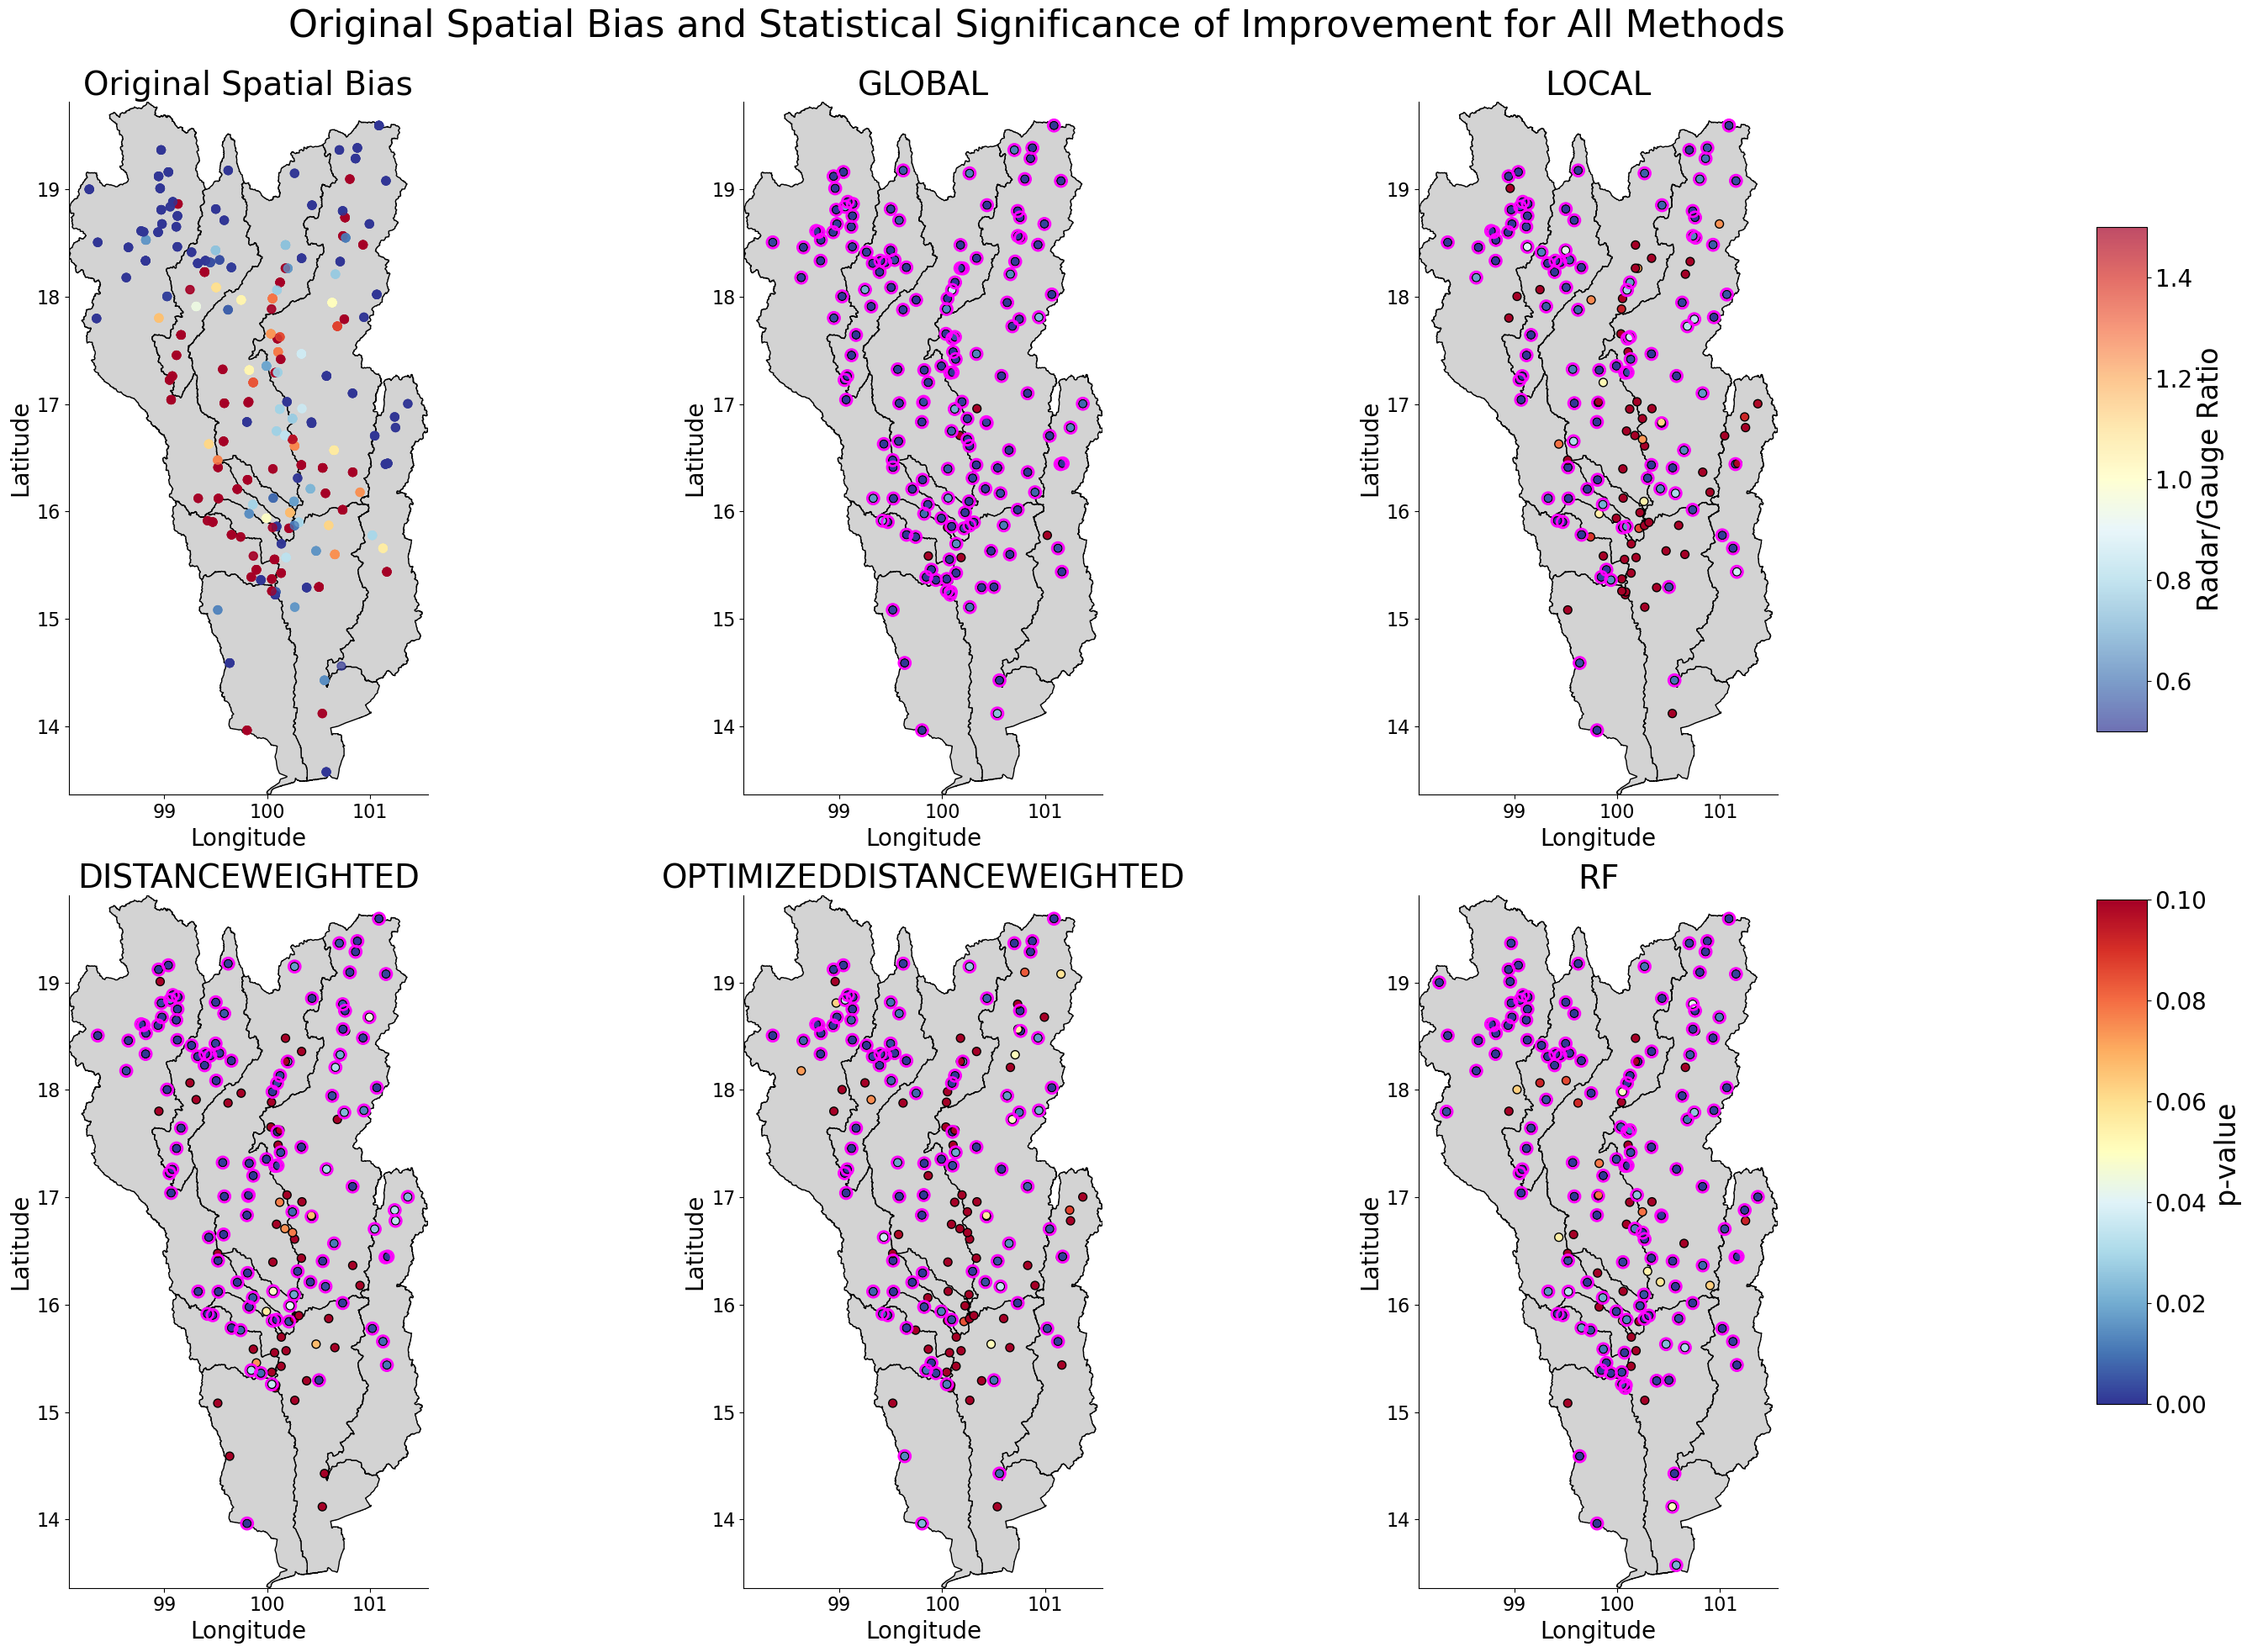

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import geopandas as gpd

def per_coordinate_statistical_tests(results):
    coordinate_results = []
    for (lat, lon), group in results.groupby(['latitude', 'longitude']):
        if len(group) > 1:
            t_stat, p_value = stats.ttest_rel(np.abs(group['bias_original'] - 1), 
                                              np.abs(group['bias_adjusted'] - 1))
            coordinate_results.append({
                'latitude': lat,
                'longitude': lon,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })
    return pd.DataFrame(coordinate_results)

def load_data(methods):
    results = {}
    for method in methods:
        results[method] = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
    return results

def setup_subplot(ax, basin_shape, title):
    basin_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
    ax.set_title(title, fontsize=28)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(labelsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(basin_shape.total_bounds[0], basin_shape.total_bounds[2])
    ax.set_ylim(basin_shape.total_bounds[1], basin_shape.total_bounds[3])

def plot_original_bias(ax, results, basin_shape):
    setup_subplot(ax, basin_shape, 'Original Spatial Bias')
    sc_original = ax.scatter(results['global']['longitude'], results['global']['latitude'], 
                             c=results['global']['bias_original'], 
                             cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=50, alpha=0.7)
    return sc_original

def plot_method_results(ax, coordinate_results, basin_shape, method):
    setup_subplot(ax, basin_shape, method.upper())
    scatter = ax.scatter(coordinate_results['longitude'], coordinate_results['latitude'], 
                         c=coordinate_results['p_value'], cmap='RdYlBu_r', 
                         s=50, edgecolor='black', vmin=0, vmax=0.1)
    significant = coordinate_results[coordinate_results['significant']]
    ax.scatter(significant['longitude'], significant['latitude'], 
               facecolors='none', edgecolors='magenta', s=100, linewidth=2)
    return scatter

def add_colorbars(fig, sc_original, scatter):
    cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
    cbar1 = fig.colorbar(sc_original, cax=cbar_ax1)
    cbar1.set_label('Radar/Gauge Ratio', fontsize=24)
    cbar1.ax.tick_params(labelsize=20)

    cbar_ax2 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
    cbar2 = fig.colorbar(scatter, cax=cbar_ax2)
    cbar2.set_label('p-value', fontsize=24)
    cbar2.ax.tick_params(labelsize=20)

def main():
    methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
    results = load_data(methods)
    basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

    fig, axes = plt.subplots(2, 3, figsize=(30, 20))
    fig.subplots_adjust(hspace=0.15, wspace=0.05)
    axes = axes.flatten()

    sc_original = plot_original_bias(axes[0], results, basin_shape)

    for i, method in enumerate(methods, start=1):
        coordinate_results = per_coordinate_statistical_tests(results[method])
        scatter = plot_method_results(axes[i], coordinate_results, basin_shape, method)

        print(f"\n{method.upper()}:")
        print(f"Total coordinates: {len(coordinate_results)}")
        print(f"Coordinates with significant improvement: {sum(coordinate_results['significant'])}")
        print(f"Percentage of coordinates with significant improvement: {sum(coordinate_results['significant']) / len(coordinate_results) * 100:.2f}%")

    add_colorbars(fig, sc_original, scatter)

    plt.suptitle('Original Spatial Bias and Statistical Significance of Improvement for All Methods', fontsize=32)
    plt.tight_layout(rect=[0, 0, 0.91, 0.98])
    plt.savefig('../3output/0map/spatial_bias_and_significant_coordinates_map_all_methods.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()

# Percent improvement

C:\Users\Admin\AppData\Local\Temp\ipykernel_3576\3083154394.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


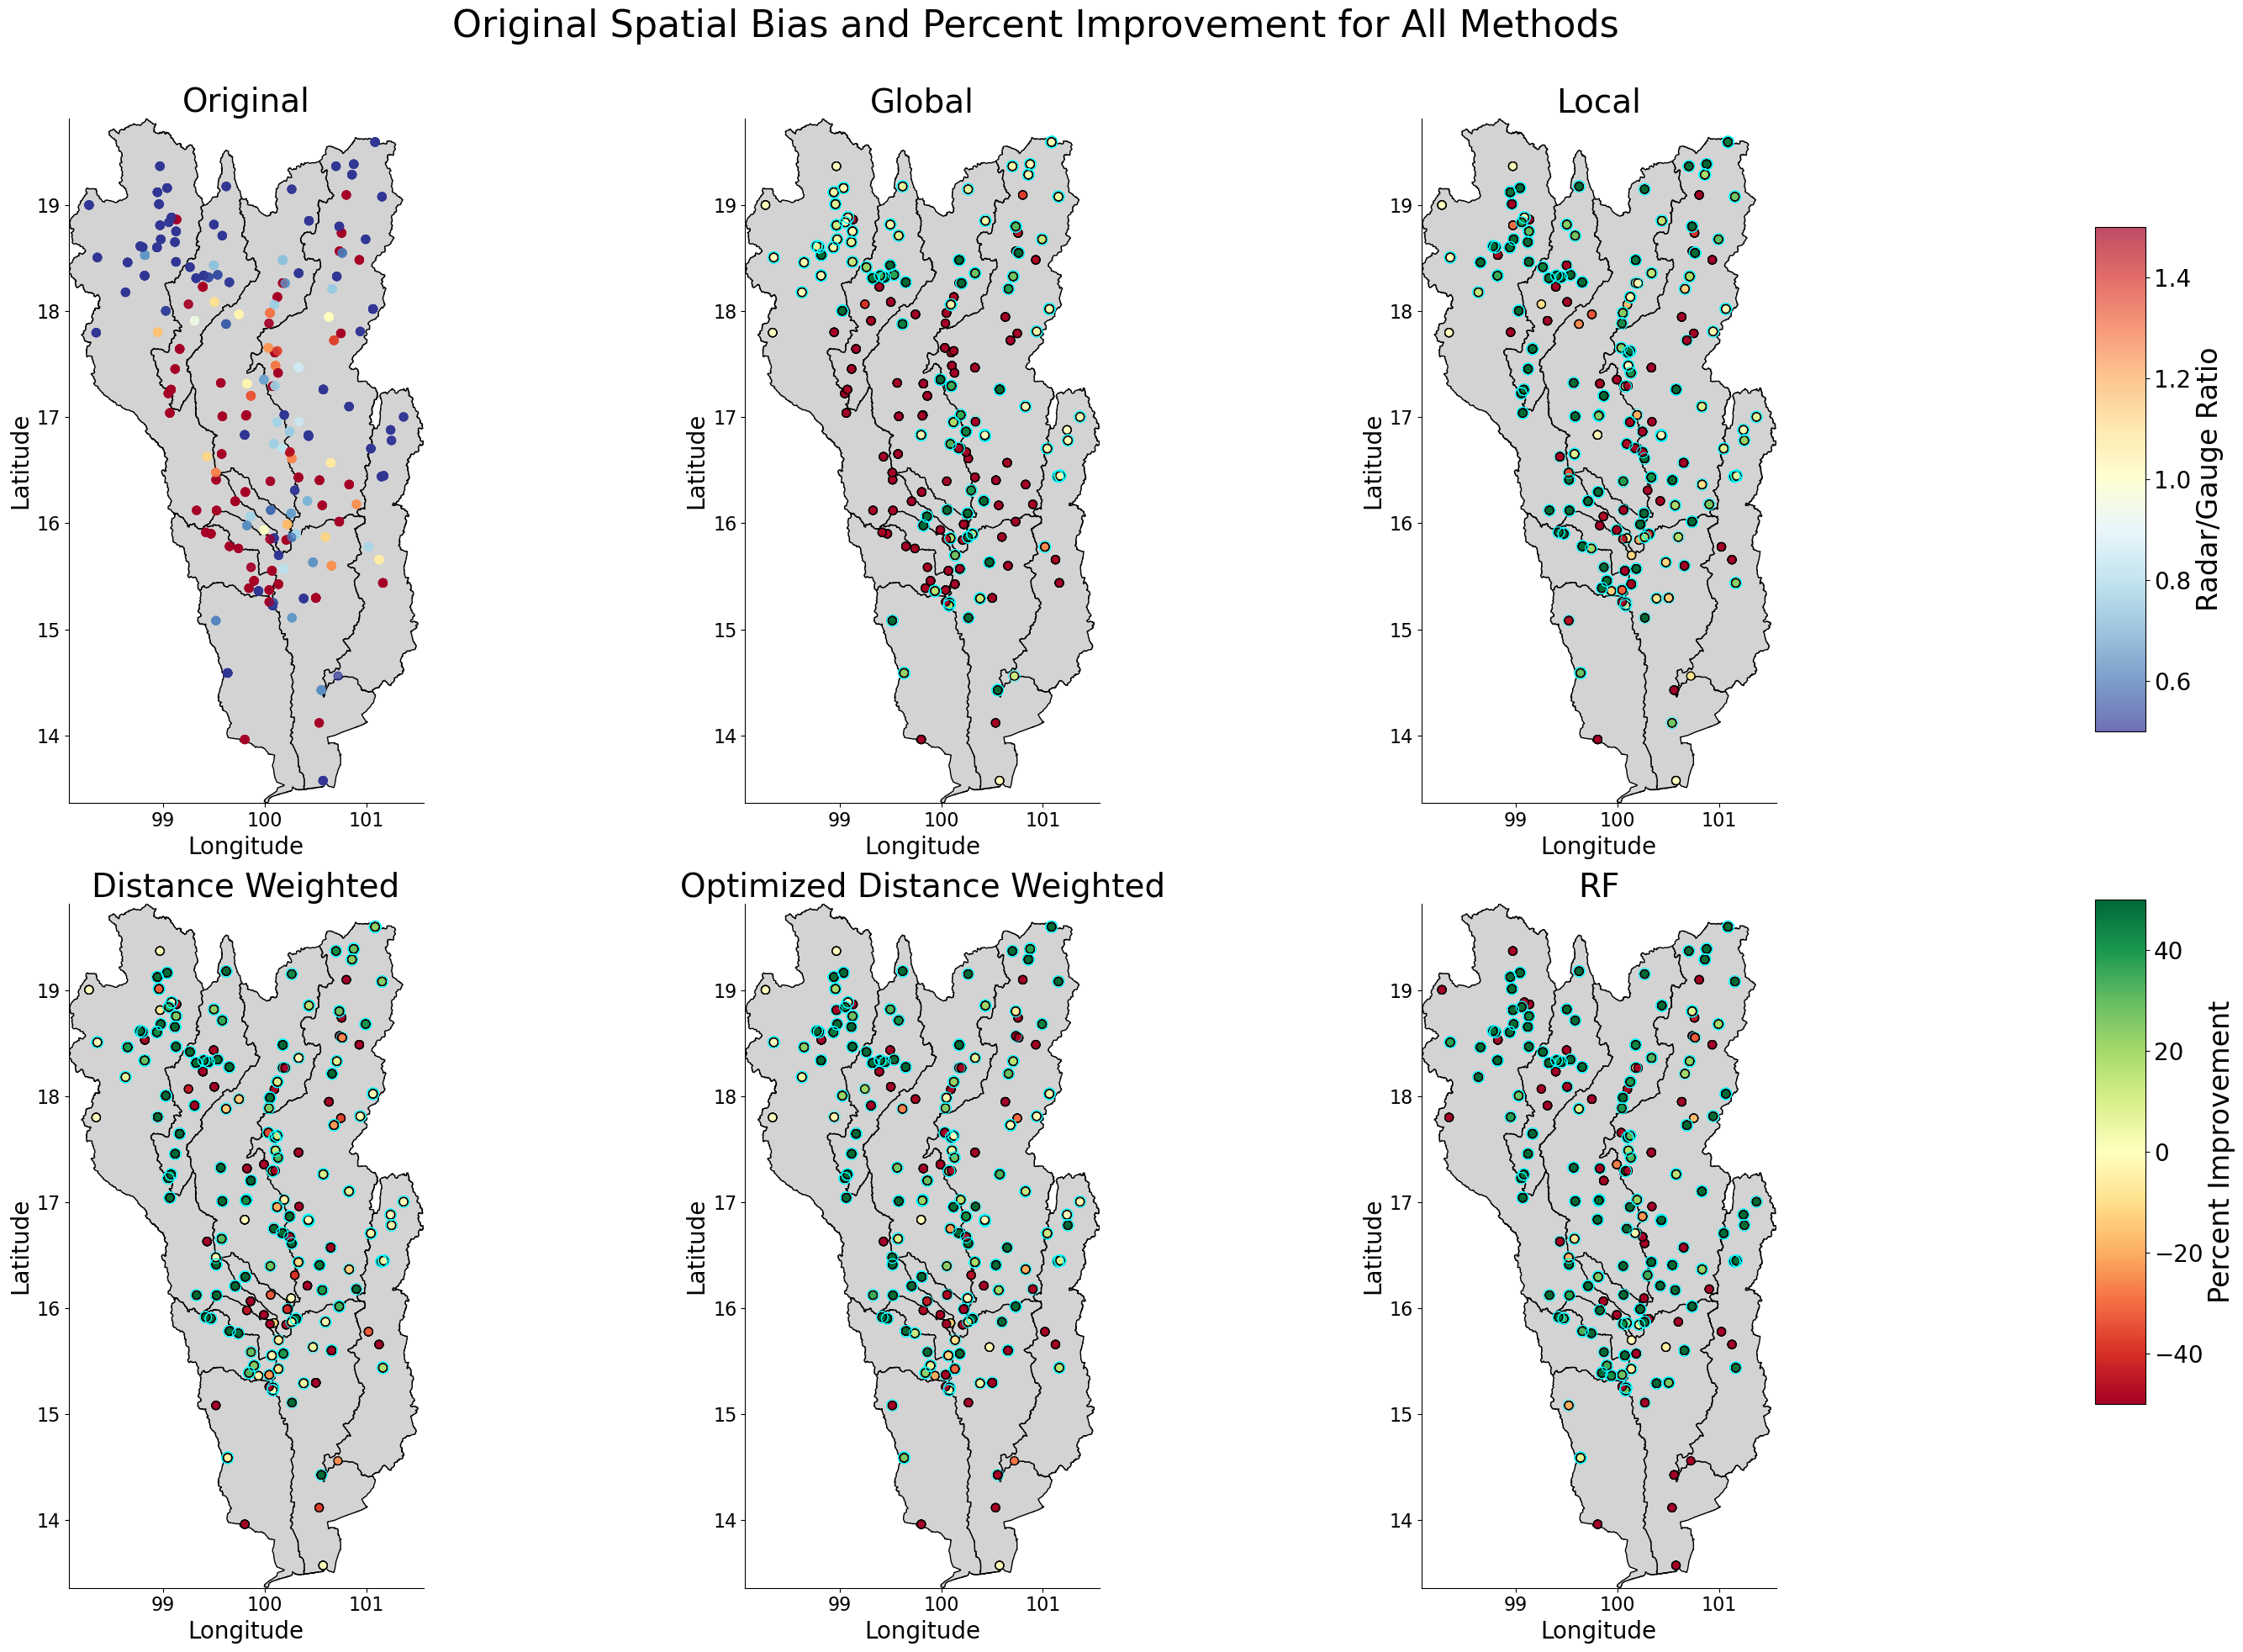


GLOBAL:
Average percent improvement: -332.02%
Median percent improvement: 0.07%
Percentage of coordinates with improvement: 51.49%
Percentage of coordinates with significant improvement: 51.49%

LOCAL:
Average percent improvement: -375.33%
Median percent improvement: 8.06%
Percentage of coordinates with improvement: 59.26%
Percentage of coordinates with significant improvement: 59.26%

DISTANCEWEIGHTED:
Average percent improvement: -138.73%
Median percent improvement: 8.68%
Percentage of coordinates with improvement: 60.11%
Percentage of coordinates with significant improvement: 60.11%

OPTIMIZEDDISTANCEWEIGHTED:
Average percent improvement: -205.05%
Median percent improvement: 10.32%
Percentage of coordinates with improvement: 58.62%
Percentage of coordinates with significant improvement: 58.62%

RF:
Average percent improvement: -323.20%
Median percent improvement: 35.34%
Percentage of coordinates with improvement: 65.74%
Percentage of coordinates with significant improvement: 65.74%

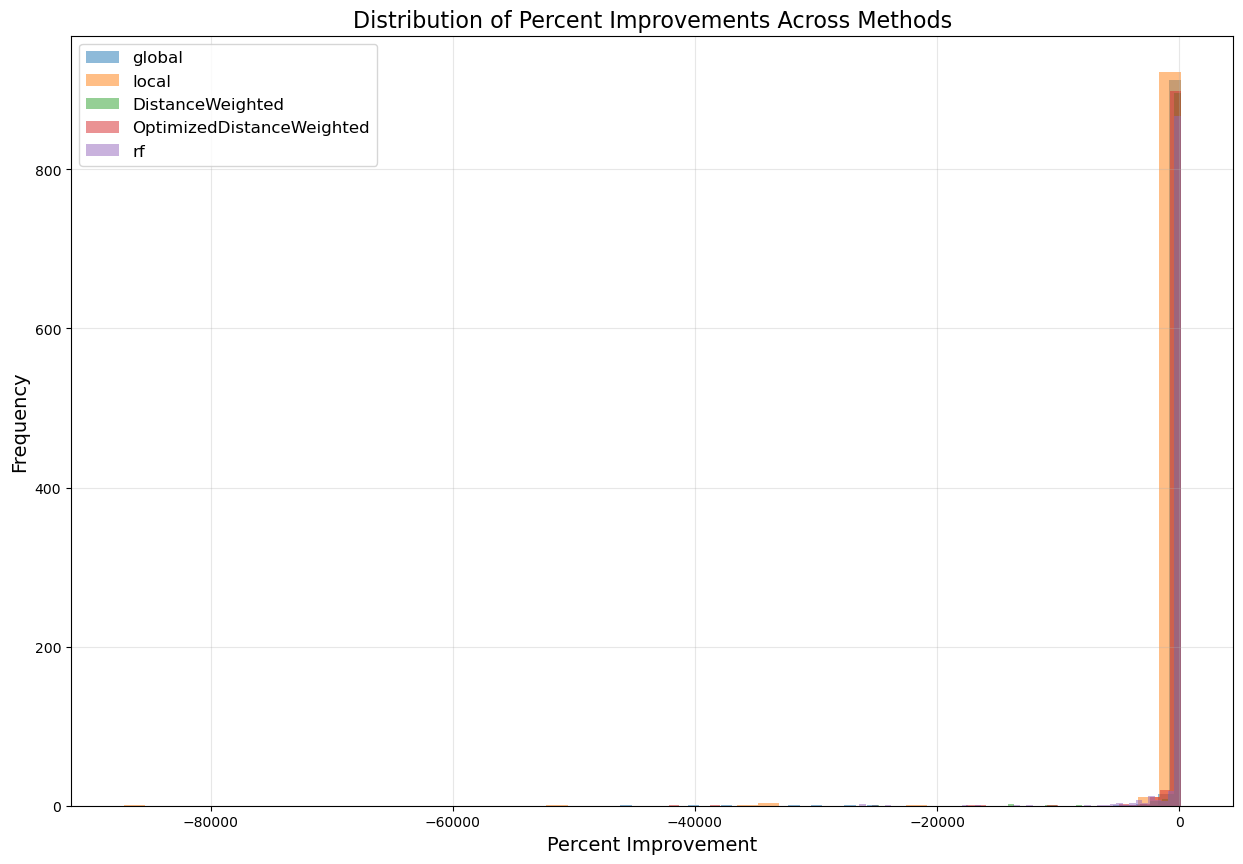

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats

def calculate_percent_improvement(results):
    original_error = np.abs(results['bias_original'] - 1)
    adjusted_error = np.abs(results['bias_adjusted'] - 1)
    
    improvement = ((original_error - adjusted_error) / original_error) * 100
    
    # Perform t-test for each coordinate
    t_stat, p_value = stats.ttest_rel(original_error, adjusted_error)
    
    return pd.DataFrame({
        'latitude': results['latitude'],
        'longitude': results['longitude'],
        'percent_improvement': improvement,
        'p_value': p_value,
        'significant': (p_value < 0.05) & (improvement > 0)
    })

# Load the results for each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
results = {}
for method in methods:
    results[method] = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')

# Load Chao Phraya Basin shapefile
basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Create a figure for all methods
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.subplots_adjust(hspace=0.05, wspace=0.025)  # Further reduce space between subplots
axes = axes.flatten()

titles = ['Original', 'Global', 'Local', 'Distance Weighted', 'Optimized Distance Weighted', 'RF']
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']

sc_original = None  # Initialize sc_original
sc_improvement = None  # Initialize sc_improvement

for i, title in enumerate(titles):
    ax = axes[i]
    basin_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    if i == 0:
        # Plot original spatial bias
        sc_original = ax.scatter(results['global']['longitude'], results['global']['latitude'], 
                                 c=results['global']['bias_original'], 
                                 cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=50, alpha=0.7)
    else:
        # Plot percent improvement for each method
        method = methods[i-1]
        improvement_results = calculate_percent_improvement(results[method])
        
        sc_improvement = ax.scatter(improvement_results['longitude'], improvement_results['latitude'], 
                                    c=improvement_results['percent_improvement'], cmap='RdYlGn', 
                                    s=50, edgecolor='black', vmin=-50, vmax=50)
        
        # Highlight significant stations
        significant = improvement_results[improvement_results['significant']]
        ax.scatter(significant['longitude'], significant['latitude'], 
                   facecolors='none', edgecolors='cyan', s=100, linewidth=0.5)
    
    ax.set_title(title, fontsize=28)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.tick_params(labelsize=16)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set consistent limits for all subplots
    ax.set_xlim(basin_shape.total_bounds[0], basin_shape.total_bounds[2])
    ax.set_ylim(basin_shape.total_bounds[1], basin_shape.total_bounds[3])

# Add colorbars
if sc_original is not None:
    cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # For original bias
    cbar1 = fig.colorbar(sc_original, cax=cbar_ax1)
    cbar1.set_label('Radar/Gauge Ratio', fontsize=24)
    cbar1.ax.tick_params(labelsize=20)

if sc_improvement is not None:
    cbar_ax2 = fig.add_axes([0.92, 0.15, 0.02, 0.3])  # For percent improvement
    cbar2 = fig.colorbar(sc_improvement, cax=cbar_ax2)
    cbar2.set_label('Percent Improvement', fontsize=24)
    cbar2.ax.tick_params(labelsize=20)

plt.suptitle('Original Spatial Bias and Percent Improvement for All Methods', fontsize=32)
plt.tight_layout(rect=[0, 0, 0.91, 0.97])
plt.savefig('../3output/0map/spatial_bias_and_percent_improvement_map_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary for each method
for method in methods:
    improvement_results = calculate_percent_improvement(results[method])
    print(f"\n{method.upper()}:")
    print(f"Average percent improvement: {improvement_results['percent_improvement'].mean():.2f}%")
    print(f"Median percent improvement: {improvement_results['percent_improvement'].median():.2f}%")
    print(f"Percentage of coordinates with improvement: {(improvement_results['percent_improvement'] > 0).mean() * 100:.2f}%")
    print(f"Percentage of coordinates with significant improvement: {improvement_results['significant'].mean() * 100:.2f}%")

# Additional analysis: distribution of improvements
plt.figure(figsize=(15, 10))
for method in methods:
    improvement_results = calculate_percent_improvement(results[method])
    plt.hist(improvement_results['percent_improvement'], bins=50, alpha=0.5, label=method)

plt.xlabel('Percent Improvement', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Percent Improvements Across Methods', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('../3output/0map/percent_improvement_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## ตรวจสอบค่า outlier เพื่อหาว่าทำไมค่า percent mean of improvement เป็นลบ

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def analyze_improvements(results, method_name):
    original_error = np.abs(results['bias_original'] - 1)
    adjusted_error = np.abs(results['bias_adjusted'] - 1)
    
    improvement = ((original_error - adjusted_error) / original_error) * 100
    
    print(f"\n{method_name.upper()}:")
    print(f"Average percent improvement: {np.mean(improvement):.2f}%")
    print(f"Median percent improvement: {np.median(improvement):.2f}%")
    print(f"5% Trimmed mean improvement: {stats.trim_mean(improvement, 0.05):.2f}%")
    print(f"Percentage of coordinates with improvement: {(improvement > 0).mean() * 100:.2f}%")
    
    # Plotting improvement distribution
    plt.figure(figsize=(10, 6))
    plt.hist(improvement, bins=50, edgecolor='black')
    plt.title(f'Distribution of Improvements - {method_name.upper()}')
    plt.xlabel('Percent Improvement')
    plt.ylabel('Frequency')
    plt.savefig(f'../3output/0map/improvement_distribution_{method_name}.png')
    plt.close()
    
    # Identify extreme cases
    worst_cases = results.loc[improvement.nsmallest(10).index]
    best_cases = results.loc[improvement.nlargest(10).index]
    
    return worst_cases, best_cases

# Load and analyze each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
for method in methods:
    results = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
    worst_cases, best_cases = analyze_improvements(results, method)
    
    print("\nWorst 10 cases:")
    print(worst_cases[['latitude', 'longitude', 'bias_original', 'bias_adjusted']])
    
    print("\nBest 10 cases:")
    print(best_cases[['latitude', 'longitude', 'bias_original', 'bias_adjusted']])

# Boxplot of improvements across all methods
plt.figure(figsize=(12, 6))
improvements = []
for method in methods:
    results = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
    original_error = np.abs(results['bias_original'] - 1)
    adjusted_error = np.abs(results['bias_adjusted'] - 1)
    improvement = ((original_error - adjusted_error) / original_error) * 100
    improvements.append(improvement)

plt.boxplot(improvements, labels=methods)
plt.title('Comparison of Improvement Distributions Across Methods')
plt.ylabel('Percent Improvement')
plt.savefig('../3output/0map/improvement_boxplot_comparison.png')
plt.close()


GLOBAL:
Average percent improvement: -332.02%
Median percent improvement: 0.07%
5% Trimmed mean improvement: -35.82%
Percentage of coordinates with improvement: 51.49%

Worst 10 cases:
      latitude  longitude  bias_original  bias_adjusted
909  17.945711  100.63105       1.001225       1.566462
446  17.945711  100.63105       1.001225       1.492049
634  17.945711  100.63105       1.001225       1.462854
309  17.945711  100.63105       1.001225       1.395140
155  17.945711  100.63105       1.001225       1.368934
262  17.945711  100.63105       1.001225       1.337523
541  17.945711  100.63105       1.001225       1.311267
886  15.937154   99.99175       0.990148       1.470995
647  15.937154   99.99175       0.990148       1.446669
598  15.937154   99.99175       0.990148       1.329981

Best 10 cases:
      latitude   longitude  bias_original  bias_adjusted
360  14.427310  100.556060       0.647730       0.998430
574  18.482023  100.177530       0.747089       1.003501
620  17.355

* ค่าเฉลี่ย bias ที่เป็นลบเพราะมี outlier

# คำนวณค่าสถิติก่อนและหลังการปรับปรุงค่า bias ด้วยการตัดค่า outlier

In [6]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_improvements(results):
    original_error = np.abs(results['bias_original'] - 1)
    adjusted_error = np.abs(results['bias_adjusted'] - 1)
    
    improvement = ((original_error - adjusted_error) / original_error) * 100
    
    return improvement

def analyze_improvements_with_trimming(results, method_name, trim_percent=5):
    improvement = calculate_improvements(results)
    
    # Calculate various statistics
    mean_improvement = np.mean(improvement)
    median_improvement = np.median(improvement)
    trimmed_mean_improvement = stats.trim_mean(improvement, trim_percent/100)
    percent_improved = (improvement > 0).mean() * 100
    
    # Calculate IQR and define bounds for outliers
    Q1 = np.percentile(improvement, 25)
    Q3 = np.percentile(improvement, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_improvement = improvement[(improvement >= lower_bound) & (improvement <= upper_bound)]
    filtered_mean_improvement = np.mean(filtered_improvement)
    
    print(f"\n{method_name.upper()}:")
    print(f"Full Average percent improvement: {mean_improvement:.2f}%")
    print(f"Median percent improvement: {median_improvement:.2f}%")
    print(f"{trim_percent}% Trimmed mean improvement: {trimmed_mean_improvement:.2f}%")
    print(f"Mean improvement (IQR outliers removed): {filtered_mean_improvement:.2f}%")
    print(f"Percentage of gauges with improvement: {percent_improved:.2f}%")
    
    return improvement

# Load and analyze each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
all_improvements = {}

for method in methods:
    results = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
    all_improvements[method] = analyze_improvements_with_trimming(results, method)

# Overall comparison
print("\nOverall comparison (outliers removed):")
for method in methods:
    improvements = all_improvements[method]
    Q1 = np.percentile(improvements, 25)
    Q3 = np.percentile(improvements, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_improvements = improvements[(improvements >= lower_bound) & (improvements <= upper_bound)]
    
    print(f"{method.upper()}:")
    print(f"  Mean improvement: {np.mean(filtered_improvements):.2f}%")
    print(f"  Median improvement: {np.median(filtered_improvements):.2f}%")
    print(f"  Percentage of gauges with improvement: {(filtered_improvements > 0).mean() * 100:.2f}%")


GLOBAL:
Full Average percent improvement: -332.02%
Median percent improvement: 0.07%
5% Trimmed mean improvement: -35.82%
Mean improvement (IQR outliers removed): -16.61%
Percentage of gauges with improvement: 51.49%

LOCAL:
Full Average percent improvement: -375.33%
Median percent improvement: 8.06%
5% Trimmed mean improvement: -8.82%
Mean improvement (IQR outliers removed): 10.70%
Percentage of gauges with improvement: 59.26%

DISTANCEWEIGHTED:
Full Average percent improvement: -138.73%
Median percent improvement: 8.68%
5% Trimmed mean improvement: -2.84%
Mean improvement (IQR outliers removed): 12.80%
Percentage of gauges with improvement: 60.11%

OPTIMIZEDDISTANCEWEIGHTED:
Full Average percent improvement: -205.05%
Median percent improvement: 10.32%
5% Trimmed mean improvement: -9.77%
Mean improvement (IQR outliers removed): 10.57%
Percentage of gauges with improvement: 58.62%

RF:
Full Average percent improvement: -323.20%
Median percent improvement: 35.34%
5% Trimmed mean improv

## Box plot for percent improvement

C:\Users\Admin\AppData\Local\Temp\ipykernel_3576\2580999739.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


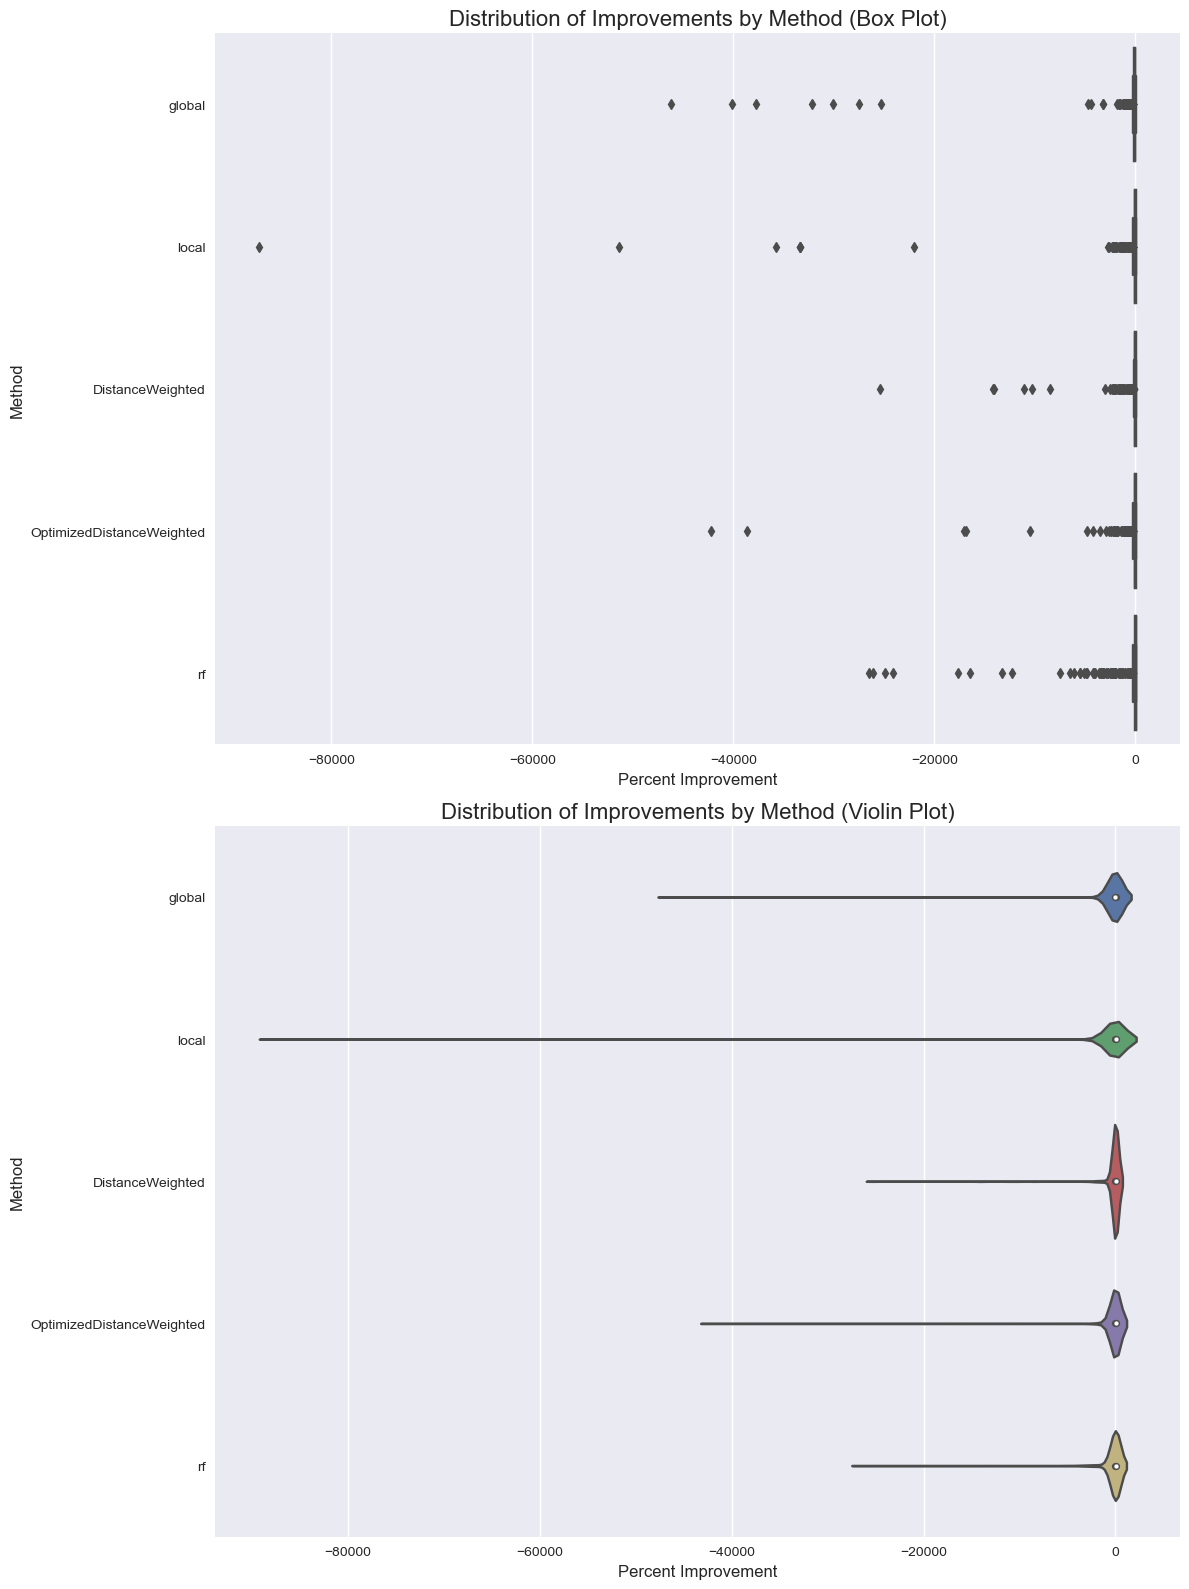


GLOBAL:
Mean: -332.02%
Median: 0.07%
Standard Deviation: 3004.97%
25th Percentile: -77.00%
75th Percentile: 18.51%

LOCAL:
Mean: -375.33%
Median: 8.06%
Standard Deviation: 4036.04%
25th Percentile: -45.79%
75th Percentile: 51.68%

DISTANCEWEIGHTED:
Mean: -138.73%
Median: 8.68%
Standard Deviation: 1221.57%
25th Percentile: -33.62%
75th Percentile: 49.01%

OPTIMIZEDDISTANCEWEIGHTED:
Mean: -205.05%
Median: 10.32%
Standard Deviation: 2076.66%
25th Percentile: -45.91%
75th Percentile: 51.94%

RF:
Mean: -323.20%
Median: 35.34%
Standard Deviation: 2044.69%
25th Percentile: -48.44%
75th Percentile: 71.87%


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_improvements(results):
    original_error = np.abs(results['bias_original'] - 1)
    adjusted_error = np.abs(results['bias_adjusted'] - 1)
    return ((original_error - adjusted_error) / original_error) * 100

# Load data and calculate improvements
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
improvements = {}

for method in methods:
    results = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
    improvements[method] = calculate_improvements(results)

# Prepare data for plotting
plot_data = pd.DataFrame({method: improvements[method] for method in methods})

# Set up the plot style
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Box plot
sns.boxplot(data=plot_data, orient='h', ax=ax1)
ax1.set_title('Distribution of Improvements by Method (Box Plot)', fontsize=16)
ax1.set_xlabel('Percent Improvement', fontsize=12)
ax1.set_ylabel('Method', fontsize=12)

# Violin plot
sns.violinplot(data=plot_data, orient='h', ax=ax2)
ax2.set_title('Distribution of Improvements by Method (Violin Plot)', fontsize=16)
ax2.set_xlabel('Percent Improvement', fontsize=12)
ax2.set_ylabel('Method', fontsize=12)

# Adjust layout and save
plt.tight_layout()
plt.savefig('../3output/0map/improvement_distribution_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
for method in methods:
    data = improvements[method]
    print(f"\n{method.upper()}:")
    print(f"Mean: {np.mean(data):.2f}%")
    print(f"Median: {np.median(data):.2f}%")
    print(f"Standard Deviation: {np.std(data):.2f}%")
    print(f"25th Percentile: {np.percentile(data, 25):.2f}%")
    print(f"75th Percentile: {np.percentile(data, 75):.2f}%")

## Global Moran I สำหรับ bias

In [8]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats
from pysal.lib import weights
from pysal.explore import esda

# Function to calculate evaluation metrics
def calculate_metrics(observed, predicted):
    metrics = {}
    metrics['MBE'] = np.mean(predicted - observed)
    metrics['MAE'] = np.mean(np.abs(predicted - observed))
    metrics['RMSE'] = np.sqrt(np.mean((predicted - observed)**2))
    metrics['PBIAS'] = 100 * np.sum(predicted - observed) / np.sum(observed) if np.sum(observed) != 0 else np.nan
    metrics['NSE'] = 1 - (np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)) if np.sum((observed - np.mean(observed))**2) != 0 else np.nan
    metrics['R'] = np.corrcoef(observed, predicted)[0, 1] if np.std(observed) != 0 and np.std(predicted) != 0 else np.nan
    return metrics

# Function to calculate MFB
def calculate_mfb(observed, predicted):
    return np.sum(predicted) / np.sum(observed)

# Function to calculate Moran's I
def calculate_morans_i(df, value_column):
    # Create a GeoDataFrame from the results
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    
    # Create a spatial weights matrix
    w = weights.distance.KNN.from_dataframe(gdf, k=5)
    
    # Calculate Moran's I
    moran = esda.moran.Moran(gdf[value_column], w)
    
    return moran.I, moran.p_sim

# Load the results for each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
results = {}
for method in methods:
    results[method] = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')

# Load Chao Phraya Basin shapefile
basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Create spatial bias maps
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.03)  # Minimize space between subplots
axes = axes.flatten()

titles = ['Original', 'Global', 'Local', 'Distance Weighted', 'Optimized Distance Weighted', 'RF']
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']

for i, title in enumerate(titles):
    ax = axes[i]
    basin_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    if i == 0:
        # Plot original bias
        sc = ax.scatter(results['global']['longitude'], results['global']['latitude'], 
                        c=results['global']['bias_original'], 
                        cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=15, alpha=0.7)
    else:
        # Plot bias for each method
        method = methods[i-1]
        sc = ax.scatter(results[method]['longitude'], results[method]['latitude'], 
                        c=results[method]['bias_adjusted'], 
                        cmap='RdYlBu_r', vmin=0.5, vmax=1.5, s=15, alpha=0.7)
    
    ax.set_title(f'Spatial Bias - {title}', fontsize=12, pad=5)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.tick_params(labelsize=8)
    ax.set_xlim(basin_shape.total_bounds[0], basin_shape.total_bounds[2])
    ax.set_ylim(basin_shape.total_bounds[1], basin_shape.total_bounds[3])

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Radar/Gauge Ratio', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar
plt.savefig('../3output/0map/spatial_bias_comparison_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print metrics for each method
print("Metrics and MFB for each method:")
for method in ['Original'] + methods:
    if method == 'Original':
        metrics = calculate_metrics(results['global']['rain'], results['global']['radar_rainfall'])
        mfb = calculate_mfb(results['global']['rain'], results['global']['radar_rainfall'])
    else:
        metrics = calculate_metrics(results[method]['rain'], results[method]['radar_rainfall_adjusted'])
        mfb = calculate_mfb(results[method]['rain'], results[method]['radar_rainfall_adjusted'])
    
    print(f"\n{method}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print(f"MFB: {mfb:.4f}")

# Calculate and print Moran's I for each method
print("\nMoran's I for each method:")
for method in ['Original'] + methods:
    if method == 'Original':
        moran_i, p_value = calculate_morans_i(results['global'], 'bias_original')
    else:
        moran_i, p_value = calculate_morans_i(results[method], 'bias_adjusted')
    
    print(f"\n{method}:")
    print(f"Moran's I: {moran_i:.4f}")
    print(f"p-value: {p_value:.4f}")

# Perform statistical tests and calculate improvements for each method
for method in methods:
    original_bias = np.abs(results[method]['bias_original'] - 1)
    corrected_bias = np.abs(results[method]['bias_adjusted'] - 1)
    
    t_stat, p_value = stats.ttest_rel(original_bias, corrected_bias)
    print(f"\n{method.upper()} - Paired t-test comparing absolute biases:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    improvement = (original_bias > corrected_bias).mean() * 100
    print(f"Percentage of points with improved bias: {improvement:.2f}%")

    # Create a histogram of bias improvement
    bias_improvement = original_bias - corrected_bias
    plt.figure(figsize=(10, 6))
    plt.hist(bias_improvement, bins=50, edgecolor='black')
    plt.title(f'Histogram of Bias Improvement - {method.upper()}', fontsize=16)
    plt.xlabel('Bias Improvement (|Original Bias - 1| - |Corrected Bias - 1|)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.savefig(f'../3output/0map/bias_improvement_histogram_{method}.png', dpi=300, bbox_inches='tight')
    plt.show()
'''

'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport geopandas as gpd\nfrom scipy import stats\nfrom pysal.lib import weights\nfrom pysal.explore import esda\n\n# Function to calculate evaluation metrics\ndef calculate_metrics(observed, predicted):\n    metrics = {}\n    metrics[\'MBE\'] = np.mean(predicted - observed)\n    metrics[\'MAE\'] = np.mean(np.abs(predicted - observed))\n    metrics[\'RMSE\'] = np.sqrt(np.mean((predicted - observed)**2))\n    metrics[\'PBIAS\'] = 100 * np.sum(predicted - observed) / np.sum(observed) if np.sum(observed) != 0 else np.nan\n    metrics[\'NSE\'] = 1 - (np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)) if np.sum((observed - np.mean(observed))**2) != 0 else np.nan\n    metrics[\'R\'] = np.corrcoef(observed, predicted)[0, 1] if np.std(observed) != 0 and np.std(predicted) != 0 else np.nan\n    return metrics\n\n# Function to calculate MFB\ndef calculate_mfb(observed, predicted):\n    return n

## Local moran I 

In [9]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Function to calculate local Moran's I
def calculate_local_morans_i(df, value_column):
    w = weights.distance.KNN.from_dataframe(df, k=8)
    local_moran = esda.moran.Moran_Local(df[value_column], w)
    df['local_moran_i'] = local_moran.Is
    df['local_moran_p'] = local_moran.p_sim
    df['local_moran_quadrant'] = local_moran.q
    return df

# Load data and calculate local Moran's I for each method
methods = ['global', 'local', 'DistanceWeighted', 'OptimizedDistanceWeighted', 'rf']
results = {}
for method in methods:
    if method == 'original':
        df = pd.read_csv('./zProcessing_temp/0results_bias/results_global.csv')
        value_column = 'bias_original'
    else:
        df = pd.read_csv(f'./zProcessing_temp/0results_bias/results_{method}.csv')
        value_column = 'bias_adjusted'
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    results[method] = calculate_local_morans_i(gdf, value_column)

# Load Chao Phraya Basin shapefile
basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Create maps
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
fig.subplots_adjust(right=0.8)
axes = axes.flatten()

# Create a common colorbar
vmin, vmax = -1, 1
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
sm.set_array([])

for i, method in enumerate(methods):
    ax = axes[i]
    basin_shape.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    # Plot local Moran's I
    sc = results[method].plot(column='local_moran_i', cmap='RdYlBu', 
                              ax=ax, legend=False,
                              vmin=vmin, vmax=vmax)
    
    # Highlight significant clusters
    significant = results[method][results[method]['local_moran_p'] <= 0.05]
    significant.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
    
    ax.set_title(f"{method.upper()}", fontsize=24)
    ax.axis('off')

# Add a common colorbar to the right of the subplots
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Local Moran's I", fontsize=24)
cbar.ax.tick_params(labelsize=20)

plt.suptitle("Local Moran's I for Different Bias Correction Methods", fontsize=32)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig('../3output/0map/local_morans_i_maps_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# Create enhanced Moran scatter plots
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    
    # Standardize the bias values
    value_column = 'bias_original' if method == 'original' else 'bias_adjusted'
    z_bias = (results[method][value_column] - results[method][value_column].mean()) / results[method][value_column].std()
    
    # Calculate spatial lag
    w = weights.distance.KNN.from_dataframe(results[method], k=8)
    lag = weights.lag_spatial(w, z_bias)
    
    # Calculate Moran's I
    moran = esda.moran.Moran(z_bias, w)
    
    # Plot scatter
    ax.scatter(z_bias, lag, alpha=0.6, c='#4393c3')
    
    # Add vertical and horizontal lines
    ax.axvline(0, c='k', alpha=0.5, linestyle='--')
    ax.axhline(0, c='k', alpha=0.5, linestyle='--')
    
    # Add regression line
    beta = moran.I
    ax.plot(z_bias, beta * z_bias, 'r')
    
    # Label quadrants
    ax.text(0.03, 0.97, 'LH', transform=ax.transAxes, fontweight='bold')
    ax.text(0.97, 0.97, 'HH', transform=ax.transAxes, ha='right', fontweight='bold')
    ax.text(0.03, 0.03, 'LL', transform=ax.transAxes, va='bottom', fontweight='bold')
    ax.text(0.97, 0.03, 'HL', transform=ax.transAxes, ha='right', va='bottom', fontweight='bold')
    
    ax.set_title(f"{method.upper()} (Moran's I: {moran.I:.3f})", fontsize=12)
    ax.set_xlabel('Standardized Bias')
    ax.set_ylabel('Spatial Lag')
    
    # Set consistent axis limits
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.savefig('../3output/0map/moran_scatter_plots_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print statistics
print("Local Moran's I Statistics:")
for method in methods:
    local_moran_i = results[method]['local_moran_i']
    significant = results[method]['local_moran_p'] <= 0.05
    
    print(f"\n{method.upper()}:")
    print(f"Mean Local Moran's I: {local_moran_i.mean():.4f}")
    print(f"Median Local Moran's I: {local_moran_i.median():.4f}")
    print(f"Standard Deviation of Local Moran's I: {local_moran_i.std():.4f}")
    print(f"Percentage of Significant Local Moran's I: {(significant.sum() / len(significant)) * 100:.2f}%")
    
    # Count of each quadrant (High-High, Low-Low, High-Low, Low-High)
    quadrant_counts = results[method]['local_moran_quadrant'].value_counts()
    print("Quadrant Counts:")
    for q in range(1, 5):
        count = quadrant_counts.get(q, 0)
        percentage = (count / len(results[method])) * 100
        print(f"  Quadrant {q}: {count} ({percentage:.2f}%)")

# Perform paired t-tests
print("\nPaired t-tests (Original vs Corrected):")
for method in methods[1:]:  # Skip 'original'
    t_stat, p_value = stats.ttest_rel(
        results['original']['local_moran_i'],
        results[method]['local_moran_i']
    )
    print(f"\n{method.upper()}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

# Additional visualization: Boxplot of Local Moran's I distributions
plt.figure(figsize=(15, 10))
boxplot_data = [results[method]['local_moran_i'] for method in methods]
plt.boxplot(boxplot_data, labels=methods)
plt.title("Distribution of Local Moran's I Across Methods", fontsize=24)
plt.ylabel("Local Moran's I", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('../3output/0map/local_morans_i_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
'''

'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport geopandas as gpd\nfrom pysal.explore import esda\nfrom pysal.lib import weights\nfrom scipy import stats\nfrom mpl_toolkits.axes_grid1 import make_axes_locatable\n\n# Function to calculate local Moran\'s I\ndef calculate_local_morans_i(df, value_column):\n    w = weights.distance.KNN.from_dataframe(df, k=8)\n    local_moran = esda.moran.Moran_Local(df[value_column], w)\n    df[\'local_moran_i\'] = local_moran.Is\n    df[\'local_moran_p\'] = local_moran.p_sim\n    df[\'local_moran_quadrant\'] = local_moran.q\n    return df\n\n# Load data and calculate local Moran\'s I for each method\nmethods = [\'global\', \'local\', \'DistanceWeighted\', \'OptimizedDistanceWeighted\', \'rf\']\nresults = {}\nfor method in methods:\n    if method == \'original\':\n        df = pd.read_csv(\'./zProcessing_temp/0results_bias/results_global.csv\')\n        value_column = \'bias_original\'\n    else:\n        df = pd.read_cs

# Stacking models try to reduce spatial autocorrelation of bias
* น่าทดลองทำการรวมผลจากแบบจำลอง ML เพื่อสร้างแบบจำลองใหม่